In [4]:
##############################################################
### Set up libraries and global variables
##############################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.constants as constants  # a collection of scientific constants
from scipy.optimize import curve_fit
from scipy.stats import linregress

!pip install uncertainties

import uncertainties as un
from uncertainties import unumpy as unp

github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"

#################################################################
### a function to fill in sigma for empty spaces in s+ and s- 
#################################################################

def fill_sigma(df):     
    for z in df.index:
        if np.isnan(df.loc[z,"s_plus"]):
            df.loc[z,"s_plus"] = df.loc[z,"sigma"]
        if np.isnan(df["s_minus"][z]):
            df.loc[z,"s_minus"] = df.loc[z,"sigma"]
    return(df)

#################################################################
### a function calculate rsq for data and a model with parameters
#################################################################

def rsq(x, y, popt, model):
    ### RSQ calc from https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
    y_calc = model(x, *popt)
    residuals = y-y_calc
    
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)   # calculate correlation constant rsq
    return(r_squared)



In [18]:
################################################################################
### Read Hammett data set. The fields are separated by commas; comments are enabled  
################################################################################

LFER_Data = "LFER_HanschLeoTaft.csv"   # Choose which set of Hammett parameters you prefer
#LFER_Data = "LFER_Williams.csv"

Filename = github_location_LFER_tables + LFER_Data

df = pd.read_csv(Filename,            # load in substituent constants from database
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="Substituent", 
                 comment = "#") 
#display(df)

################################################################################
### Fill across sigma values and select substituents 
################################################################################

df = fill_sigma(df)
display(df)

################################################################################
### Remove unneeded columns 
################################################################################
 
df.drop(labels = ["TABLE V", "TABLE I"],    #Trim "LFER_HanschLeoTaft.csv" data
#df.drop(labels = ["Page"],                   #Trim "LFER_Williams.csv"" data
        axis = 1,
        inplace = True)

df.sort_values(by=['sigma'], inplace=True)

#result = pd.concat([df2, df], axis=1, join="inner")   # combine the experimental data and the Hammett parameters



,sigma,s_plus,s_minus,sigma_I,sigma_n,F,R,R+,R-,TABLE V,TABLE I
Substituent,,,,,,,,,,,
m-Br,0.39,0.39,0.39,NaN,NaN,NaN,0.00,0.00,0.00,NaN,2
p-Br,0.23,0.15,0.25,0.47,0.230,0.45,-0.22,-0.30,-0.20,2,2
m-C6H5,0.06,0.06,0.06,NaN,NaN,NaN,0.00,0.00,0.00,NaN,417
p-C6H5,-0.01,0.02,-0.18,0.12,NaN,0.12,-0.13,-0.30,-0.10,183 & Charton,417
m-CCCH3,0.21,0.21,0.21,NaN,NaN,NaN,0.00,0.00,0.00,NaN,267
...,...,...,...,...,...,...,...,...,...,...,...
p-N(CH3)2,-0.83,-1.70,-0.12,0.17,-0.172,0.15,-0.98,-1.85,-0.27,99,231
p-N2C6H5,0.39,-0.19,0.45,NaN,NaN,0.30,0.09,-0.49,0.15,184,419
m-N2C6H5,0.32,0.32,0.32,NaN,NaN,NaN,0.00,0.00,0.00,NaN,419


In [20]:
################################################################################
### Data for plot
################################################################################

list = ["m-Br", "p-OCH3", "p-Cl", "p-Br", "p-CH3", "m-CH3", "p-CN", "m-NO2", "p-NO2",]
#x = df["sigma"][list]   # pull out corresponding sigma values from dataframe

df2 = df[["sigma","sigma_I", "sigma_n","F"]]
numbers = np.array([0.18, 1, 0.2, 0.25, 0.8, 0.75, 0.05, 0.05, 0.04])
#y = np.log10(numbers)

df2 = df2.dropna()
#plt.plot(x, y, "ko")
x = df2["F"]

y = df2["sigma_n"]
y = df2["sigma_I"]

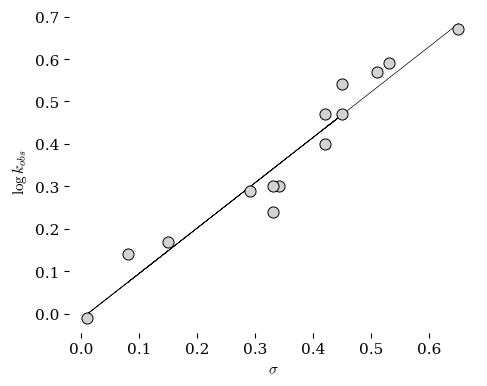

slope is 1.069+/-0.078
intercept is -0.011+/-0.031
rsq is 0.940


In [21]:
################################################################################
### Define Models and other functions
################################################################################

def linear_model(x, m, b):
       y = m*x + b
       return(y)

def linear_model1(x, b):
       y = 1*x + b
       return(y)


################################################################################
### Curve Fit to Model
################################################################################

popt, pcov = curve_fit(linear_model, x, y)   # curve fit data to model

################################################################################
### Plot Data
################################################################################

plt.rcdefaults()                  # reset plot styles (just in case)

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)         # use a chosen style sheet (or not)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))    # create empty plot
#ax.margins(x=.07, y=.07, tight=True)

ax.scatter(x, y,                  # plot the data points
           s=64, color="lightgray", marker='o', 
           edgecolors = "black", linewidth = 0.7, 
           alpha = 1, zorder=3)

y_calc = linear_model(x, *popt)   # calculate line values using optimize parameters

ax.plot(x, y_calc,                # plot the line for optimized parameters
           color="black", marker=None, 
           linewidth = 0.5, 
           alpha = 1, zorder=2)

ax.set(                           # set options for plot appearance
#    title="Yukawa-Tsuno Plot",       
          ylabel=r"$\log{k_{obs}}$", 
          xlabel=r"$\sigma$",                
#          xlim=[-.9,.9],                  
#          ylim=[-3.7,-2.7]
       )

fig.savefig("starter.pdf")   # use this to save the figure in PDF format
plt.show()

################################################################################
### report
################################################################################

popt_u = un.correlated_values(popt,pcov) # use covariance matrix and parameters to make uncertain parameters

print(f"slope is {popt_u[0]:0.3f}")
print(f"intercept is {popt_u[1]:0.3f}")
print(f"rsq is {rsq(x,y,popt,linear_model):0.3f}")

In [11]:
################################################################################
### Data for problem 3 of sample exam
################################################################################

list = ["m-Cl","m-F","m-OCH3","H","m-CH3","p-OCH3"]
x = df["sigma"][list]   # pull out corresponding sigma values from dataframe

numbers = np.array([2.23, 2.21, 1.77, 1.00, 0.77, 0.60 ])
y = np.log10(numbers)




#plt.plot(x, y, "ko")
#print(x,y)

In [14]:
################################################################################
### Data for problem 4 of sample exam
################################################################################

list = ["H","p-OCH3","p-CH3","p-Br","p-NO2"]
x = df["sigma"][list]   # pull out corresponding sigma values from dataframe

numbers = np.array([37.4, 21.3, 24.0, 95.1, 1430])
y = np.log10(numbers)


#plt.plot(x, y, "ko")
#print(x,y)

In [23]:
################################################################################
### Data for problem 4 of sample exam
################################################################################

list = ["p-OCH3", "p-CH3", "p-F", "H", "m-NO2", "p-NO2", "p-Cl", "m-Cl"]
x = df["sigma"][list]   # pull out corresponding sigma values from dataframe

numbers = np.array([9.32, 9.22, 8.94, 9.03, 8.19, 8.14, 8.83, 8.67])
#y = np.log10(numbers)
y = -numbers

#plt.plot(x, y, "ko")
#print(x,y)